# 构建朴素预测模型:用过去四小时的真实值作为未来四小时的预测值

## 1 读取辐照度数据和光伏有功功率数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch
import warnings
import random
warnings.filterwarnings("ignore")
def set_random_seed(seed_value):
    """设置随机种子"""
    np.random.seed(seed_value)  # NumPy
    random.seed(seed_value)  # Python
    torch.manual_seed(seed_value)  # PyTorch CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)  # PyTorch GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
#设置随机种子
set_random_seed(42)
#设置设备
device='cuda' if torch.cuda.is_available() else 'cpu'
#读取辐照度数据
df_weather=pd.read_csv('weatherdata.csv')
#读取光伏有功功率数据
df_power=pd.read_csv('pvdata.csv')

#打印数据查看数据字段是否符合预期
print(df_weather.head(5))
print(df_power.head(5))

#检查是否含有缺失值，如果有缺失值，采用线性插值的方式填充
df_weather.interpolate(method='linear',inplace=True)
df_power.interpolate(method='linear',inplace=True)

#去除时间戳列
df_weather.drop(columns=['timestamp'],inplace=True)
df_power.drop(columns=['timestamp'],inplace=True)


             timestamp  Global_Horizontal_Radiation
0  2015-01-01 00:00:00                          0.0
1  2015-01-01 00:05:00                          0.0
2  2015-01-01 00:10:00                          0.0
3  2015-01-01 00:15:00                          0.0
4  2015-01-01 00:20:00                          0.0
             timestamp  activePower
0  2015-01-01 00:00:00          0.0
1  2015-01-01 00:05:00          0.0
2  2015-01-01 00:10:00          0.0
3  2015-01-01 00:15:00          0.0
4  2015-01-01 00:20:00          0.0


## 2 划分训练集、验证集、测试集，并使用训练集的参数进行归一化，避免信息泄露

torch.Size([32, 48, 1]) torch.Size([32, 48, 1]) torch.Size([32, 48, 1])


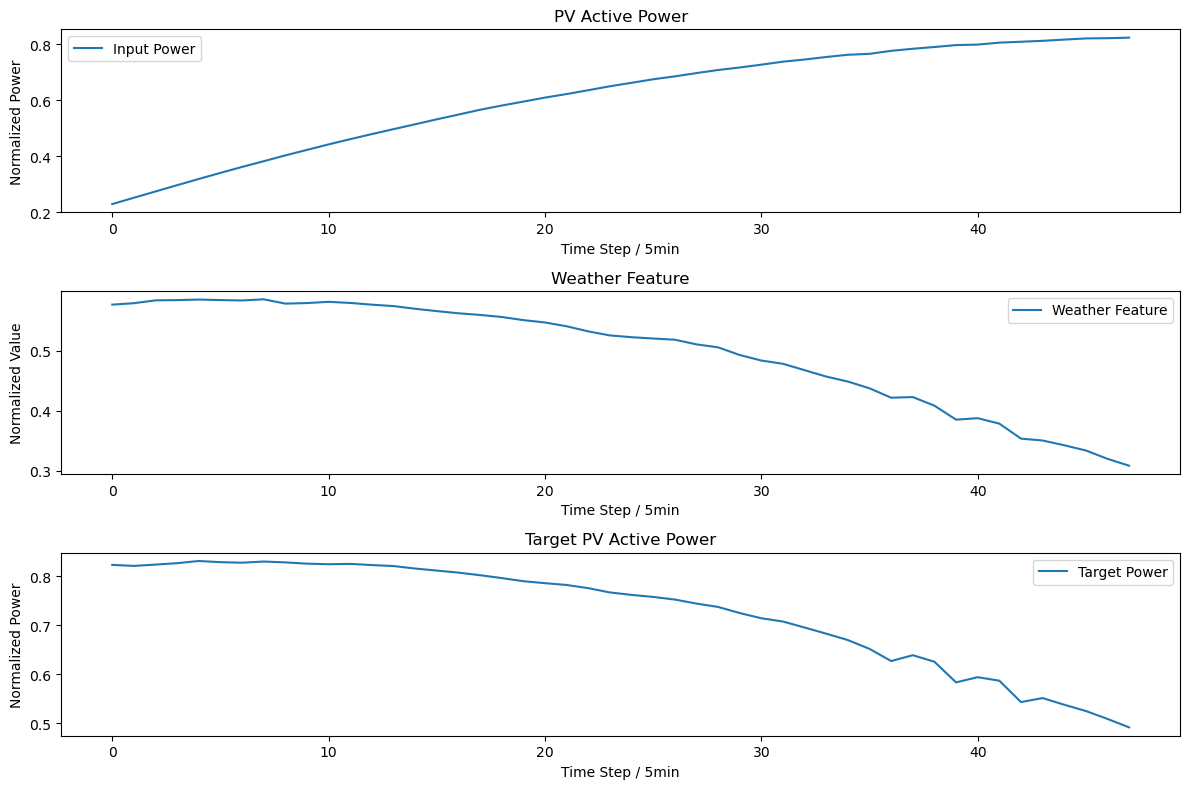

In [2]:
#定义数据集
class PVData(Dataset):
    def __init__(self, power,weather,input_len,output_len,step):
        self.power = power
        self.weather = weather
        self.input_len=input_len
        self.output_len=output_len
        self.step=step 
    
    def __len__(self):
        return (len(self.power)-self.input_len-self.output_len)//self.step+1
    def __getitem__(self, index):
        power_start=index*self.step
        power_end=power_start+self.input_len

        weather_start=power_end
        weather_end=weather_start+self.output_len

        target_start=power_end
        target_end=target_start+self.output_len

        power_seq=self.power[power_start:power_end]
        weather_seq=self.weather[weather_start:weather_end]
        target_seq=self.power[target_start:target_end]

        return torch.Tensor(power_seq),torch.Tensor(weather_seq),torch.Tensor(target_seq)
    
#划分数据集
train_ratio,val_ratio,test_ratio=0.7,0.1,0.2
data_len=len(df_power)
train_len=int(data_len*train_ratio)
val_len=int(data_len*val_ratio)
test_len=data_len-train_len-val_len

#训练集
power_train=df_power[:train_len]
weather_train=df_weather[:train_len]
#验证集
power_val=df_power[train_len:train_len+val_len]
weather_val=df_weather[train_len:train_len+val_len]
#测试集
power_test=df_power[train_len+val_len:]
weather_test=df_weather[train_len+val_len:]

#归一化
weather_scaler=MinMaxScaler()
power_scaler=MinMaxScaler()
#对训练集进行归一化
weather_train=weather_scaler.fit_transform(weather_train)
power_train=power_scaler.fit_transform(power_train)
#使用训练集参数对验证集和测试集归一化
weather_val=weather_scaler.transform(weather_val)
weather_test=weather_scaler.transform(weather_test)
power_val=power_scaler.transform(power_val)
power_test=power_scaler.transform(power_test)

#设置批次大小，并创建数据加载器
batch_size=32
input_len=48 #输入数据长度
output_len=48 #输出数据长度
step=48 #样本间的不重复时间步长
train_dataset=PVData(power_train,weather_train,input_len,output_len,step)
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataset=PVData(power_val,weather_val,input_len,output_len,step)
val_loader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_dataset=PVData(power_test,weather_test,input_len,output_len,step)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

#测试数据加载器是否正常
#获取一个批次的数据
for power_seq,weather_seq,target_seq in train_loader:
    print(power_seq.shape,weather_seq.shape,target_seq.shape)
    #绘制三个子图
    fig, axs = plt.subplots(3, 1, figsize=(12, 8))
    # 绘制输入有功功率子图
    axs[0].plot(power_seq[0, :, 0], label='Input Power')
    axs[0].set_title('PV Active Power')
    axs[0].set_xlabel('Time Step / 5min')
    axs[0].set_ylabel('Normalized Power')
    axs[0].legend()
    # 绘制天气子图
    axs[1].plot(weather_seq[0, :, 0], label='Weather Feature')
    axs[1].set_title('Weather Feature')
    axs[1].set_xlabel('Time Step / 5min')
    axs[1].set_ylabel('Normalized Value')
    axs[1].legend()
    # 绘制目标光伏有功功率子图
    axs[2].plot(target_seq[0, :, 0], label='Target Power')
    axs[2].set_title('Target PV Active Power')
    axs[2].set_xlabel('Time Step / 5min')
    axs[2].set_ylabel('Normalized Power')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

    break

## 3 测试朴素预测模型的效果（无需训练，只需要对测试集进行测试即可）

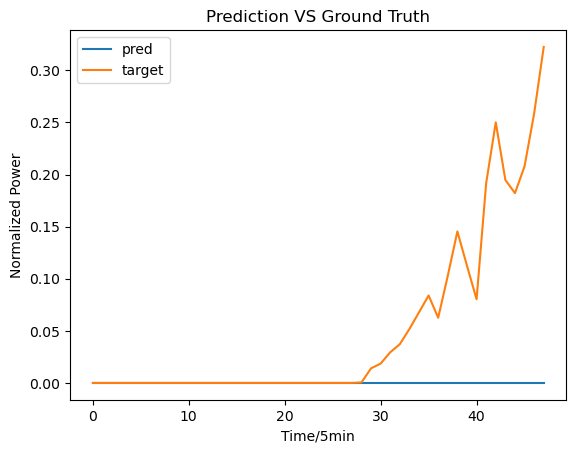

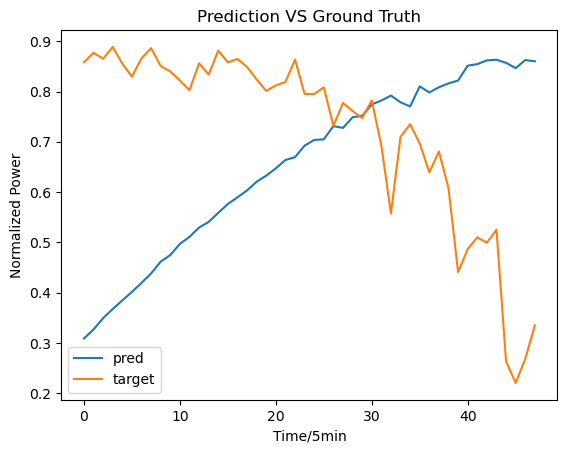

朴素预测模型的预测精度如下：
MSE: 0.135094
MAE: 0.251076
R2 : -0.358162


In [3]:
#测试朴素预测模型的预测精度
all_pred_seq=[]
all_target_seq=[]
for i,(power_seq,weather_seq,target_seq) in enumerate(test_loader):
    #设置设备
    power_seq=power_seq.to(device)
    weather_seq=weather_seq.to(device)
    target_seq=target_seq.to(device)
    #将过去4小时的光伏有功功率作为预测值
    pred_seq=power_seq[:,-output_len:,:] #适用于输入长度大于输出长度的情况
    #保存结果到CPU
    all_pred_seq.append(pred_seq.detach().cpu())
    all_target_seq.append(target_seq.detach().cpu())
    if i % 10 ==0:
        plt.plot(pred_seq[0,:,0].numpy(),label='pred')
        plt.plot(target_seq[0,:,0].numpy(),label='target')
        plt.title('Prediction VS Ground Truth')
        plt.xlabel('Time/5min')
        plt.ylabel('Normalized Power')
        plt.legend()
        plt.show()

#拼接所有batch
all_pred_seq=torch.cat(all_pred_seq,dim=0) # 形状为(B,L,C)
all_target_seq=torch.cat(all_target_seq,dim=0) # 形状为(B,L,C)

# 去掉特征维 (B, L, 1) -> (B, L)
pred = all_pred_seq.squeeze(-1)
target = all_target_seq.squeeze(-1)

# 展平为一维 (B * L)
pred_np = pred.numpy().reshape(-1)
target_np = target.numpy().reshape(-1)

# === 指标计算 ===
mse = mean_squared_error(target_np, pred_np)
mae = mean_absolute_error(target_np, pred_np)
r2 = r2_score(target_np, pred_np)

print('朴素预测模型的预测精度如下：')
print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"R2 : {r2:.6f}")